In [1]:
import numpy as np
import pickle
import os
import tarfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import wandb

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms


In [ ]:
# Extract cifar-100-python.tar.gz to separate data
with tarfile.open("cifar-100-python.tar.gz", 'r|gz') as f:
        f.extractall(path="./")
        f.close()

In [2]:
data = pickle.load(open(os.path.join("cifar-100-python", "train"), 'rb'), encoding='latin1')
X_train_np = data['data']
y_train_np = np.asarray(data['fine_labels'], np.int8)

data = pickle.load(open(os.path.join('cifar-100-python', 'test'), 'rb'), encoding='latin1')
X_test_np = data['data']
y_test_np = np.asarray(data['fine_labels'], np.int8)

In [3]:
# reshape
X_train_np = X_train_np.reshape(-1, 3, 32, 32)
X_test_np = X_test_np.reshape(-1, 3, 32, 32)


In [4]:
X_train_np.shape

(50000, 3, 32, 32)

D:\Git\NSIETE\Zadanie 2\.env_zadanie2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

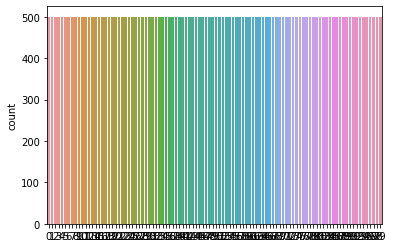

In [5]:
sns.countplot(y_train_np)

TypeError: Invalid shape (3, 32, 32) for image data

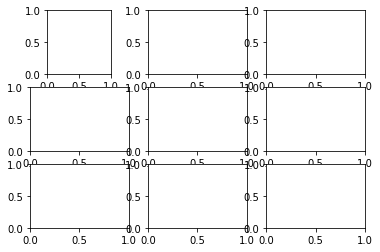

In [6]:
x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(X_train_np[y*y_max+x+offset])
# print(y_train[i])
# plt.imshow(np.rollaxis(X_train[i], 0, 3))

In [7]:
mean = X_train_np.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
std = X_train_np.std(axis=(0,1,2), keepdims=True).astype(np.float32)

X_train_np = (X_train_np - mean) / std
X_test_np = (X_test_np - mean) / std

In [8]:
def train_test_split_v2(X_train,y_train,test_size,random_state=None,sample_limit=None):
    total_count = len(X_train)
    if sample_limit:
        _, X_train, _, y_train = train_test_split(X_train, y_train, test_size=1/(total_count/sample_limit), random_state=random_state)
    return train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [9]:
X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=None, test_size=1/6, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0]+X_valid.shape[0])


(41666, 3, 32, 32)
(8334, 3, 32, 32)
50000


In [10]:
class CIFAR(Dataset):
    def __init__(self, X,y,transform=None):
        self.X=X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = self.X[index]
        label = self.y[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [78]:
train_data = CIFAR(X_train,y_train, transform=transforms.ToTensor())
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=256)
valid_loader = DataLoader(dataset=valid_data,batch_size=256)

In [79]:
dataiter=iter(train_loader)
images, labels = dataiter.next()
images = images.permute(0,2,1,3)
print('images shape: ', images.size())
print('labels shape: ', labels.size())

images shape:  torch.Size([256, 3, 32, 32])
labels shape:  torch.Size([256])


In [11]:
class SimpleNet(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8192,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class Net(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [19]:

learning_rate=0.001
betas = (0.9,0.999)
batch_size = 128
sample_limit = 2000
epochs = 200


In [ ]:
model = Net(3,100)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, betas=betas)
loss_fn = nn.CrossEntropyLoss()


X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=sample_limit, test_size=1/6, random_state=42)

train_data = CIFAR(X_train,y_train, transform=transforms.ToTensor())
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=batch_size)
valid_loader = DataLoader(dataset=valid_data,batch_size=batch_size)

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []


torch.manual_seed(7)

for epoch in range(epochs):
    model.train()

    train_losses = []
    valid_losses = []

    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model.forward(images.permute(0,2,1,3))
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    model.eval()
    correct = 0 
    total = 0
    
    with torch.no_grad():
        for i,(images,labels) in enumerate(valid_loader):
            output = model.forward(images.permute(0,2,1,3))
            loss = loss_fn(output,labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(output.data,1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    
    print('Epoch: {}, train loss: {:.4f}, valid loss: {:.4f}, valid acc: {:.2f}%'.format(epoch+1,mean_train_losses[-1],mean_valid_losses[-1],accuracy))

Epoch: 1, train loss: 4.6661, valid loss: 4.7065, valid acc: 0.30%
Epoch: 2, train loss: 4.6840, valid loss: 4.6480, valid acc: 1.20%
Epoch: 3, train loss: 4.6589, valid loss: 4.7748, valid acc: 1.50%
Epoch: 4, train loss: 4.6441, valid loss: 4.7669, valid acc: 1.80%
Epoch: 5, train loss: 4.6418, valid loss: 4.6062, valid acc: 0.90%
Epoch: 6, train loss: 4.6031, valid loss: 4.6060, valid acc: 0.90%
Epoch: 7, train loss: 4.6065, valid loss: 4.6072, valid acc: 0.30%
Epoch: 8, train loss: 4.6141, valid loss: 4.6065, valid acc: 0.90%
Epoch: 9, train loss: 4.6015, valid loss: 4.6067, valid acc: 0.90%
Epoch: 10, train loss: 4.5983, valid loss: 4.6070, valid acc: 0.30%
Epoch: 11, train loss: 4.5955, valid loss: 4.6073, valid acc: 0.30%


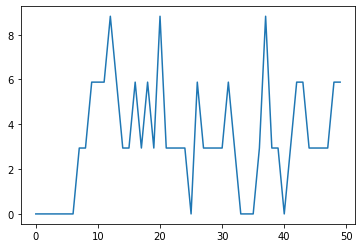

In [18]:
fig, (plot1,plot2) = plt.subplots(nrows=1,ncols=2,figsize=(8,12))
plot1.plot(mean_train_losses, label="Train mean loss")
plot1.plot(mean_valid_losses, label="Valid mean loss")
plot1.legend(loc="best")

plot2.plot(valid_acc_list,label="Vallid accuracy")
plot2.legend()

In [81]:
output.shape

torch.Size([256, 100])